This example shows how to simulate and plot the characteristic curve of
a diode.

Theory
======

A diode is a semiconductor device made of a PN junction which is a
sandwich of two doped silicon layers.


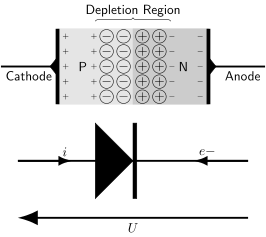

Before two explains the purpose of the silicon doping. We will give a
quick and simplified look on the atomic world. An atom is made of the
same number of protons and electrons, this number is so called Z and
characterise the atom. Each electron is coupled to the proton\'s kernel
by the electromagnetic interaction, but with different levels of energy.
The reason is due to the fact each electron screens each other. There is
thus some electrons which are strongly coupled and other ones which are
weakly coupled, so called valence\'s electrons. An atom is a neutral
object when we observe it at a large distance, but when the pressure and
temperature of the environment match some conditions, the weakly coupled
electrons can be shared with atoms in the neighbourhood and create the
electromagnetic interaction between atoms which make the cohesion of the
matter.

Depending on the weakness of the electrons, an atom can be an insulated
material or a conductor. Semiconductors are between them.

The doping consists to diffuse a small quantities of atoms with a larger
or smaller number of valence electron in a silicon layer. Since a
silicon atom has four valence electrons, we use atoms having 3 or 5
valence electrons for the doping. A doping using a larger number of
valence electrons is called N for negative, and P respectively. In a
silicon lattice doped with atoms having a larger number of valence
electrons, the additional electrons do not participate to the lattice
cohesion and are weakly coupled to the atoms. The conductivity is thus
improved. In other hands, a silicon lattice doped with atoms having a
smaller number of valence electrons, some electrons are missing for the
lattice cohesion. These missing electrons are called holes since the P
doping atoms will catch free electrons so as to normalise the lattice
cohesion.

When we make a sandwich of P and N doped silicon layers, the weak
electrons of the N layer diffuse to the P layer until an equilibrium
state is achieved. Indeed this diffusion creates a depletion region
which acts as a barrier to the electrons, since a P doping atom becomes
negative (anion) when it catches an electron and reciprocally a N doping
atom becomes positive (cation) when it lost an electron. The depletion
region is thus a kind of capacitor.

The volume of the depletion region can be changed by applying a tension
across the PN junction. If the tension between the PN junction is
negative then the depletion region is enlarged, and only a very small
current can flow through the junction due to the thermal agitation. But
if we apply a positive tension, the depletion region is pressurised, and
if it reaches a threshold, an electron flow will be able to pass through
the junction.

A PN junction can thus only conduct a current from the anode to the
cathode and only if a minimal bias tension is applied across it.

However if a large enough inverse tension is applied to the junction
then the electrostatic force will become sufficiently large enough to
pull off electrons across the junction and the current will flow from
the cathode to the anode. This effect is called breakdown.

Simulation
==========


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Physics.SemiConductor import ShockleyDiode


libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)




For this purpose, we use the common high-speed diode 1N4148. The diode
is driven by a variable voltage source through a limiting current
resistance.


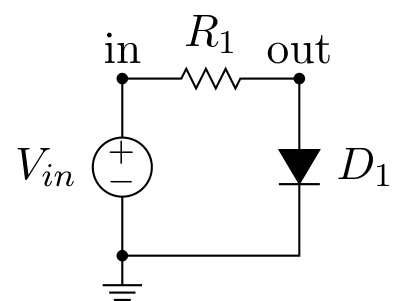

In [ ]:

circuit = Circuit('Diode Characteristic Curve')

circuit.include(spice_library['1N4148'])

circuit.V('input', 'in', circuit.gnd, 10@u_V)
circuit.R(1, 'in', 'out', 1@u_Ω) # not required for simulation
circuit.X('D1', '1N4148', 'out', circuit.gnd)



SubCircuitElement XD1

We simulate the circuit at these temperatures: 0, 25 and 100 °C.


In [ ]:

# Fixme: Xyce ???
temperatures = [0, 25, 100]@u_Degree
analyses = {}
for temperature in temperatures:
    simulator = circuit.simulator(temperature=temperature, nominal_temperature=temperature)
    analysis = simulator.dc(Vinput=slice(-2, 5, .01))
    analyses[float(temperature)] = analysis




We plot the characteristic curve and compare it to the Shockley diode
model:

$$I_d = I_s \left( e^{\frac{V_d}{n V_T}} - 1 \right)$$

where $V_T = \frac{k T}{q}$

In order to scale the reverse biased region, we have to do some hack
with Matplotlib.


Text(1, -100, 'Forward Biased Region')

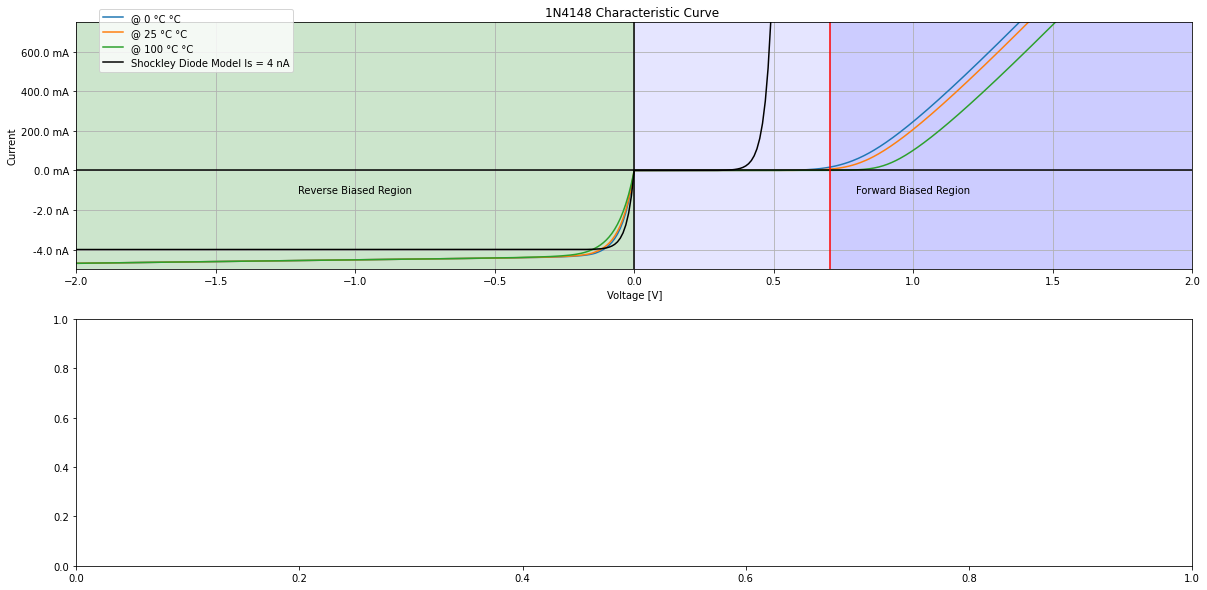

In [ ]:

silicon_forward_voltage_threshold = .7

shockley_diode = ShockleyDiode(Is=4e-9, degree=25)

def two_scales_tick_formatter(value, position):
    if value >= 0:
        return '{} mA'.format(value)
    else:
        return '{} nA'.format(value/100)
formatter = ticker.FuncFormatter(two_scales_tick_formatter)

figure, (ax1, ax2) = plt.subplots(2, figsize=(20, 10))

ax1.set_title('1N4148 Characteristic Curve ')
ax1.set_xlabel('Voltage [V]')
ax1.set_ylabel('Current')
ax1.grid()
ax1.set_xlim(-2, 2)
ax1.axvspan(-2, 0, facecolor='green', alpha=.2)
ax1.axvspan(0, silicon_forward_voltage_threshold, facecolor='blue', alpha=.1)
ax1.axvspan(silicon_forward_voltage_threshold, 2, facecolor='blue', alpha=.2)
ax1.set_ylim(-500, 750) # Fixme: round
ax1.yaxis.set_major_formatter(formatter)
Vd = analyses[25].out
# compute scale for reverse and forward region
forward_region = Vd >= 0@u_V
reverse_region = np.invert(forward_region)
scale =  reverse_region*1e11 + forward_region*1e3
for temperature in temperatures:
    analysis = analyses[float(temperature)]
    ax1.plot(Vd, - analysis.Vinput * scale)
ax1.plot(Vd, shockley_diode.I(Vd) * scale, 'black')
ax1.legend(['@ {} °C'.format(temperature)
            for temperature in temperatures] + ['Shockley Diode Model Is = 4 nA'],
           loc=(.02,.8))
ax1.axvline(x=0, color='black')
ax1.axhline(y=0, color='black')
ax1.axvline(x=silicon_forward_voltage_threshold, color='red')
ax1.text(-1, -100, 'Reverse Biased Region', ha='center', va='center')
ax1.text( 1, -100, 'Forward Biased Region', ha='center', va='center')



Now we compute and plot the static and dynamic resistance.

$$\frac{d I_d}{d V_d} = \frac{1}{n V_T}(I_d + I_s)$$

$$r_d = \frac{d V_d}{d I_d} \approx \frac{n V_T}{I_d}$$


In [ ]:

ax2.set_title('Resistance @ 25 °C')
ax2.grid()
ax2.set_xlim(-2, 3)
ax2.axvspan(-2, 0, facecolor='green', alpha=.2)
ax2.axvspan(0, silicon_forward_voltage_threshold, facecolor='blue', alpha=.1)
ax2.axvspan(silicon_forward_voltage_threshold, 3, facecolor='blue', alpha=.2)
analysis = analyses[25]
static_resistance = -analysis.out / analysis.Vinput
dynamic_resistance = np.diff(-analysis.out) / np.diff(analysis.Vinput)
ax2.semilogy(analysis.out, static_resistance, basey=10)
ax2.semilogy(analysis.out[10:-1], dynamic_resistance[10:], basey=10)
ax2.axvline(x=0, color='black')
ax2.axvline(x=silicon_forward_voltage_threshold, color='red')
ax2.axhline(y=1, color='red')
ax2.text(-1.5, 1.1, 'R limitation = 1 Ω', color='red')
ax2.legend(['{} Resistance'.format(x) for x in ('Static', 'Dynamic')], loc=(.05,.2))
ax2.set_xlabel('Voltage [V]')
ax2.set_ylabel('Resistance [Ω]')

plt.tight_layout()



<Figure size 432x288 with 0 Axes>

We observe the forward voltage threshold increase with the temperature.
